# Import Libraries

In [62]:
import gurobipy as grb
import pandas as pd
from gurobipy import GRB
import numpy as np
import json

# Model

In [63]:
 # Create a model
model = grb.Model("Model")

# Get data from json

In [64]:
# get the  data from the json file small.json
def get_data(size = 'small'):
    with open(size + '.json') as f:
        data = json.load(f)
    return data
data = get_data('../medium')

## Constants from data

In [65]:

horizon= data['horizon']
qualifications=data['qualifications']
staff_names=[i['name'] for i in data['staff']]
staff_qualifications=[i['qualifications'] for i in data['staff']]
job_list=[i['name'] for i in data['jobs']]
jour_list=[i for i in range(1,horizon+1)]
job_penality=[i['daily_penalty'] for i in data['jobs']] 
job_qualifications= [i['working_days_per_qualification'] for i in data['jobs']]
job_gain=[i['gain'] for i in data['jobs']]
due_dates=[i['due_date'] for i in data['jobs']]
vacation_staff=[i['vacations'] for i in data['staff']]

    

# Model's parameters

#### Objective 1
H : days

Q : qualifications

S : staff

J : jobs

qi : qualifications of i

qj : qualifications of j

vi : vacation days of i

njk : required work load for j with k

cj : daily penalty of j

gj : gain of j

dj : due date of j

yj : is j completely done

lj : delay in days for j

ej : end date of j

pi_j_k_t : work is done by i with k for j on t

#### Objective 2
aij : j is assigned to i

ni : number of jobs i works on

max_i : max of ni

### Objective 3
sj : start date for j

nj : length in days for j

max_j : maximum of nj

In [66]:
H = [i for i in range(1,horizon+1)]
Q = qualifications
S = staff_names
J = job_list
# Parameters for each staff

qi = {}
for i in range(len(staff_names)) :
    k = staff_names[i]
    qi[k] = []
    for c in qualifications:
        if c in data['staff'][i]['qualifications']:
            qi[k].append(c)
vi={}
for ind,i in enumerate(staff_names):
    vi[i] = []
    for j in jour_list:
        if j in vacation_staff[ind]:
            vi[i].append(j)
#vi=staff_in_vacation.to_dict(orient='index')

# Parameters for each job
qj = dict()
for ind, j in enumerate(job_list):
    qj[j] = list(job_qualifications[ind].keys())
njk = dict(zip(job_list,job_qualifications))
cj=job_penality_dict=dict(zip(job_list,job_penality))
gj=job_gain_dict=dict(zip(job_list,job_gain))
dj = dict(zip(job_list,due_dates))

# Decision variables

In [67]:
# Objective 1
pijkt = model.addVars(staff_names,job_list,qualifications,jour_list, vtype=GRB.BINARY, name="pijkt")

yj = model.addVars(job_list, vtype=GRB.BINARY, name="yj")
lj = model.addVars(job_list, vtype=GRB.INTEGER, name="lj")
ej = model.addVars(job_list, vtype=GRB.INTEGER, name="ej")

# Objective 2
max_i = model.addVar(vtype=GRB.INTEGER, name="max_i")
ni = model.addVars(S, vtype=GRB.INTEGER, name="ni")
aij = model.addVars(S, J, vtype=GRB.BINARY, name="aij")

# Objective 3
sj = model.addVars(J, vtype=GRB.INTEGER, name="sj")
nj = model.addVars(J, vtype=GRB.INTEGER, name="nj")
max_j = model.addVar(vtype=GRB.INTEGER, name="max_j")

# Constraints

### Objective 1

In [68]:
constr1 = {f'constr1{i}_{t}':model.addConstr( grb.quicksum(pijkt[i,j,k,t] for j in J for k in Q) <= 1 , name=f"constr1{i}_{t}")
  for i in S
  for t in H}

constr2 = {f'constr2{i}_{t}':model.addConstr( grb.quicksum(pijkt[i,j,k,t] for j in J for k in Q) == 0 , name=f"constr2{i}_{t}")
  for i in S
  for t in vi[i]}

constr3 = {f'constr3{i}_{j}_{k}_{t}':model.addConstr( pijkt[i,j,k,t] == 0 , name=f"constr3{i}_{j}_{k}_{t}")
  for i in S
  for j in J
  for k in Q if k not in qj[j] or k not in qi[i]
  for t in H}

constr4 = {f'constr4{j}_{k}': model.addConstr( yj[j]*njk[j][k] <= grb.quicksum(pijkt[i,j,k,t] for i in S for t in H) , name=f"constr4{j}_{k}")
  for j in J
  for k in qj[j]}

constr5 = {f'constr5{j}_{k}': model.addConstr( grb.quicksum(pijkt[i,j,k,t] for i in S for t in H) <= njk[j][k] , name=f"constr5{j}_{k}")
  for j in J
  for k in qj[j]}

constr6 = {f'constr6{i}_{j}_{k}_{t}':model.addConstr( pijkt[i,j,k,t]*t <= ej[j] , name=f"constr6{i}_{j}_{k}_{t}")
  for i in S
  for j in J
  for k in Q
  for t in H}

constr7 = {f'constr7{j}' : model.addConstr( ej[j] - dj[j] <= lj[j] , name =f"constr7{j}")
  for j in J}

constr8 = {f'constr8{j}' : model.addConstr( 1 <= ej[j] , name =f"constr8{j}")
  for j in J}

constr9 = {f'constr9{j}' : model.addConstr( ej[j] <= H[-1] , name =f"constr9{j}")
  for j in J}

### Objective 2

In [69]:
# assigned jobs to a staff member i is aij[i, j]
constr10 = {f'constr10{i}_{j}_{k}_{t}' : model.addConstr( pijkt[i,j,k,t] <= aij[i, j] , name = f"constr10{i}_{j}_{k}_{t}")
    for i in S
    for j in J
    for k in Q
    for t in H}

# number of jobs assigned to a staff member i is ni[i]
constr11 = {f'constr11{i}' : model.addConstr( grb.quicksum(aij[i, j] for j in J) <= ni[i] , name = f"constr11{i}")
    for i in S}

# max_i max number of jobs assigned to a staff member
# for all staff i, number of jobs assigned to i is less than or equal to max_i
constr12 = {f'constr12{i}' : model.addConstr( ni[i] <= max_i , name = f"constr12{i}")
    for i in S}

### Objective 3

In [70]:
# start date is at least 1
constr14 = {f'constr14_{j}' : model.addConstr( 1 <= sj[j] , name = f"constr14_{j}")
    for j in J}

# start date of j is sj[j]
constr15 = {f'constr15{i}_{j}_{k}_{t}' : model.addConstr( sj[j] <= t*pijkt[i,j,k,t] + H[-1]*(1-pijkt[i,j,k,t]) , name = f"constr15{i}_{j}_{k}_{t}")
    for i in S
    for j in J
    for k in Q
    for t in H}

# length of a job j is nj[j]
constr16 = {f'constr16{j}' : model.addConstr( ej[j] + 1 - sj[j] <= nj[j] , name = f"constr16{j}")
    for j in J}

# max_j max of nj[j]
constr17 = {f'constr17{j}' : model.addConstr( nj[j]  <= max_j , name = f"constr17{j}")
  for j in J  }

# Objectives

The function below filters the dominated solutions from the list of solutions.

In [71]:
def filter_dominated_solutions(pareto, curr):
    for sol in pareto:
        if all(curr[v] <= sol[v] for v in range(3)):
            return pareto
        elif all(curr[v] >= sol[v] for v in range(3)):
            pareto.remove(sol)
    pareto.append((curr[0],curr[1],curr[2]))
    return pareto

In [72]:
# Set a TimeLimit 
model.setParam('TimeLimit', 0.5*60)

Set parameter TimeLimit to value 30


In [73]:
# Epsilon Constraints
eps2s = [i for i in range(len(J), 0, -1)]
eps3s = [i for i in range(len(H), 0, -1)]
pareto = []
n = len(eps2s)*len(eps3s)
i = 0
for eps2 in eps2s:
    for eps3 in eps3s:
        print("Progression : ", (i+1)/(n), "%")
        i += 1
        # constraint for objective 2
        constrobj2 = model.addConstr( max_i <= eps2 , name = "constrobj2")
        constrobj4 = model.addConstr( max_i >= eps2 , name = "constrobj4")
        # constraint for objective 3
        constrobj3 = model.addConstr( max_j <= eps3 , name = "constrobj3")
        constrobj5 = model.addConstr( max_j >= eps3 , name = "constrobj5")

        # Objective 1
        model.setObjective( grb.quicksum((gj[j]*yj[j] - lj[j]*cj[j]) for j in J) , GRB.MAXIMIZE)

        # Paramétrage (mode mute)
        model.params.outputflag = 0
        # Résolution du PL
        
        try :
            model.optimize()
            # print(model.objVal,max_i.x,max_j.x)
            #print('parzeto',pareto)
            pareto = filter_dominated_solutions(pareto,(model.objVal, -eps2, -eps3))
            #pareto.append((model.objVal, eps2, eps3))
            model.remove(constrobj2)
            model.remove(constrobj3)
            model.remove(constrobj4)
            model.remove(constrobj5)
        except :
            print(eps2,eps3)

Progression :  0.0030303030303030303 %
Progression :  0.006060606060606061 %
Progression :  0.00909090909090909 %
Progression :  0.012121212121212121 %
Progression :  0.015151515151515152 %
Progression :  0.01818181818181818 %
Progression :  0.021212121212121213 %
Progression :  0.024242424242424242 %
Progression :  0.02727272727272727 %
Progression :  0.030303030303030304 %
Progression :  0.03333333333333333 %
Progression :  0.03636363636363636 %
Progression :  0.03939393939393939 %
Progression :  0.04242424242424243 %
Progression :  0.045454545454545456 %
Progression :  0.048484848484848485 %
Progression :  0.051515151515151514 %
Progression :  0.05454545454545454 %
Progression :  0.05757575757575758 %
Progression :  0.06060606060606061 %
Progression :  0.06363636363636363 %
Progression :  0.06666666666666667 %
Progression :  0.0696969696969697 %
Progression :  0.07272727272727272 %
Progression :  0.07575757575757576 %
Progression :  0.07878787878787878 %
Progression :  0.08181818181

In [74]:
for ind,val in enumerate(pareto) :
    pareto[ind] = (val[0],-val[1],-val[2])
pareto

[(377.0, 9, 4),
 (411.0, 8, 6),
 (406.0, 8, 5),
 (374.0, 8, 4),
 (392.0, 7, 5),
 (413.0, 6, 8),
 (411.0, 6, 7),
 (408.0, 6, 6),
 (385.0, 6, 5),
 (358.0, 6, 4),
 (265.0, 6, 3),
 (413.0, 5, 10),
 (410.0, 5, 8),
 (403.0, 5, 7),
 (387.0, 5, 6),
 (379.0, 5, 5),
 (328.0, 5, 4),
 (250.0, 5, 3),
 (405.0, 4, 12),
 (404.0, 4, 9),
 (396.0, 4, 8),
 (385.0, 4, 6),
 (344.0, 4, 5),
 (300.0, 4, 4),
 (225.0, 4, 3),
 (382.0, 3, 12),
 (379.0, 3, 9),
 (370.0, 3, 8),
 (340.0, 3, 7),
 (323.0, 3, 6),
 (313.0, 3, 5),
 (273.0, 3, 4),
 (186.0, 3, 3),
 (326.0, 2, 12),
 (325.0, 2, 9),
 (305.0, 2, 8),
 (245.0, 2, 6),
 (232.0, 2, 5),
 (210.0, 2, 4),
 (155.0, 2, 3),
 (194.0, 1, 12),
 (180.0, 1, 8),
 (130.0, 1, 6),
 (120.0, 1, 5),
 (90.0, 1, 4),
 (80.0, 1, 3),
 (30.0, 1, 2),
 (-0.0, 1, 1)]

## Plot the non-dominated solutions

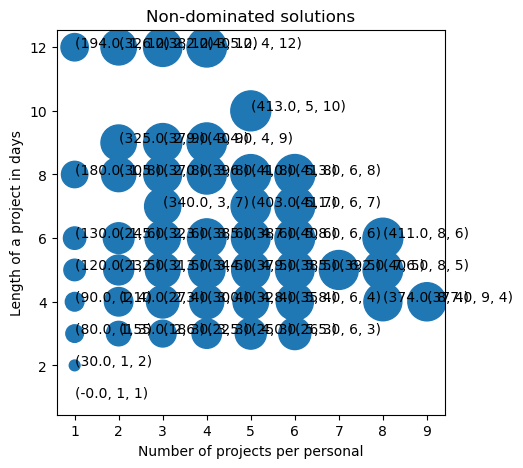

In [75]:
import matplotlib.pyplot as plt
# plot a 3d scatter with the pareto list print the labels of each point and set a different color for each point
fig = plt.figure(figsize=(5,5))
# Create the scatter plot
plt.scatter([i[1] for i in pareto], [i[2] for i in pareto],s = [i[0]*2 for i in pareto])
# Add a title and labels for the x and y axes
for i in pareto:
    plt.text(i[1] + 0.01, i[2]+0.01,  '%s' % (str(i)), size=10, zorder=1, color='k')
plt.title("Non-dominated solutions")
plt.xlabel("Number of projects per personal")
plt.ylabel("Length of a project in days")

# Show the plot
plt.show()

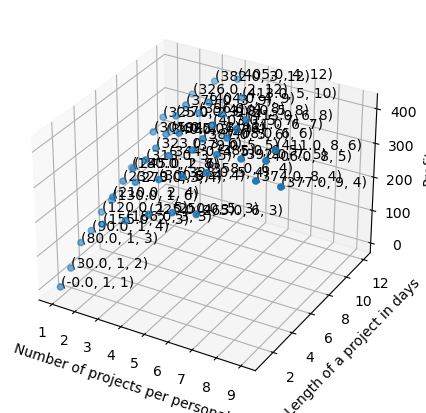

In [76]:
# Plot the pareto surface with the 3d scatter plot

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter([i[1] for i in pareto], [i[2] for i in pareto], [i[0] for i in pareto])
for i in pareto:
    ax.text(i[1] + 0.01, i[2]+0.01, i[0]+0.01,  '%s' % (str(i)), size=10, zorder=1, color='k')
ax.set_xlabel('Number of projects per personal')
ax.set_ylabel('Length of a project in days')
ax.set_zlabel('Profit')
plt.show()

# Preferences

## Weighted Sum

![](Capture%20d%E2%80%99%C3%A9cran%202023-02-09%20%C3%A0%2014.36.21.png)

In [77]:
# create max dictionary with max values of each objective
max_dict = {0: max([i[0] for i in pareto]), 1: max([i[1] for i in pareto]), 2: max([i[2] for i in pareto])}

# somme pondérée des objectifs
def score(sol, w_1, w_2, w_3):
    return w_1*sol[0]/max_dict[0] - w_2*sol[1]/max_dict[1] - w_3*sol[2]/max_dict[2]

pareto_scores = [round(score(sol, 3, 2, 1.05), 2) for sol in pareto]

# pareto_sorted is a dictionary with the score as key and the solution as value ordered by score descending order
pareto_sorted = {pareto_scores[i]: pareto[i] for i in range(len(pareto_scores))}
pareto_sorted = dict(sorted(pareto_sorted.items(), reverse=True))
pareto_sorted

{1.38: (385.0, 4, 6),
 1.32: (370.0, 3, 8),
 1.3: (379.0, 3, 9),
 1.29: (396.0, 4, 8),
 1.26: (404.0, 4, 9),
 1.2: (379.0, 5, 5),
 1.19: (340.0, 3, 7),
 1.18: (387.0, 5, 6),
 1.17: (313.0, 3, 5),
 1.15: (323.0, 3, 6),
 1.13: (325.0, 2, 9),
 1.11: (408.0, 6, 6),
 1.07: (305.0, 2, 8),
 1.06: (382.0, 3, 12),
 1.04: (411.0, 6, 7),
 1.03: (385.0, 6, 5),
 1.01: (413.0, 5, 10),
 1.0: (405.0, 4, 12),
 0.97: (273.0, 3, 4),
 0.94: (300.0, 4, 4),
 0.92: (328.0, 5, 4),
 0.87: (326.0, 2, 12),
 0.85: (392.0, 7, 5),
 0.81: (245.0, 2, 6),
 0.8: (232.0, 2, 5),
 0.73: (210.0, 2, 4),
 0.68: (411.0, 8, 6),
 0.59: (374.0, 8, 4),
 0.48: (225.0, 4, 3),
 0.44: (250.0, 5, 3),
 0.42: (155.0, 2, 3),
 0.39: (180.0, 1, 8),
 0.33: (265.0, 6, 3),
 0.21: (120.0, 1, 5),
 0.2: (130.0, 1, 6),
 0.14: (194.0, 1, 12),
 0.1: (80.0, 1, 3),
 0.08: (90.0, 1, 4),
 -0.18: (30.0, 1, 2),
 -0.31: (-0.0, 1, 1)}

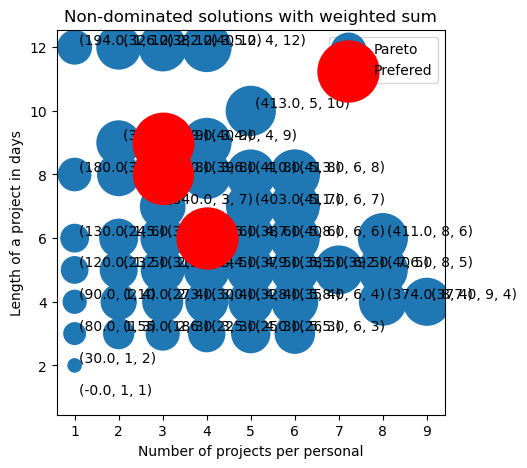

In [78]:
# Create the scatter plot
fig = plt.figure(figsize=(5,5))
plt.scatter([i[1] for i in pareto], [i[2] for i in pareto],s = [i[0]*3 for i in pareto])
# Add a title and labels for the x and y axes
for i in pareto:
    plt.text(i[1] + 0.1, i[2]+0.1,  '%s' % (str(i)), size=10, zorder=1, color='k')

# color the 3 best solutions in red according to pareto_sorted
for i in range(3):
    plt.scatter([pareto_sorted[list(pareto_sorted.keys())[i]][1]], [pareto_sorted[list(pareto_sorted.keys())[i]][2]],s = [pareto_sorted[list(pareto_sorted.keys())[i]][0]*5], color = 'red')

plt.title("Non-dominated solutions with weighted sum")
plt.xlabel("Number of projects per personal")
plt.ylabel("Length of a project in days")
plt.legend(['Pareto', 'Prefered'])

# Show the plot
plt.show()


## Borda Rule

![](Capture%20d%E2%80%99%C3%A9cran%202023-02-09%20%C3%A0%2014.46.34.png)

In [79]:
for ind,val in enumerate(pareto) :
    pareto[ind] = (val[0],-val[1],-val[2])
pareto

[(377.0, -9, -4),
 (411.0, -8, -6),
 (406.0, -8, -5),
 (374.0, -8, -4),
 (392.0, -7, -5),
 (413.0, -6, -8),
 (411.0, -6, -7),
 (408.0, -6, -6),
 (385.0, -6, -5),
 (358.0, -6, -4),
 (265.0, -6, -3),
 (413.0, -5, -10),
 (410.0, -5, -8),
 (403.0, -5, -7),
 (387.0, -5, -6),
 (379.0, -5, -5),
 (328.0, -5, -4),
 (250.0, -5, -3),
 (405.0, -4, -12),
 (404.0, -4, -9),
 (396.0, -4, -8),
 (385.0, -4, -6),
 (344.0, -4, -5),
 (300.0, -4, -4),
 (225.0, -4, -3),
 (382.0, -3, -12),
 (379.0, -3, -9),
 (370.0, -3, -8),
 (340.0, -3, -7),
 (323.0, -3, -6),
 (313.0, -3, -5),
 (273.0, -3, -4),
 (186.0, -3, -3),
 (326.0, -2, -12),
 (325.0, -2, -9),
 (305.0, -2, -8),
 (245.0, -2, -6),
 (232.0, -2, -5),
 (210.0, -2, -4),
 (155.0, -2, -3),
 (194.0, -1, -12),
 (180.0, -1, -8),
 (130.0, -1, -6),
 (120.0, -1, -5),
 (90.0, -1, -4),
 (80.0, -1, -3),
 (30.0, -1, -2),
 (-0.0, -1, -1)]

In [80]:
# Borda Rule
# Rank all the solutions for each objective
# The best solution for each objective is ranked 1, the second best is ranked 2, etc.
# The sum of the ranks for each objective is the score for each solution
pareto1 = pareto.copy()
# Objective 1
pareto1.sort(key=lambda x: x[0], reverse=True)
for ind,val in enumerate(pareto1) :
    pareto1[ind] = ([ind+1],val[0],val[1],val[2])
# Objective 2
pareto1.sort(key=lambda x: x[2], reverse=True)
for ind,val in enumerate(pareto1) :
    pareto1[ind] = (val[0] + [ind +1],val[1],val[2],val[3])

# Objective 3
pareto1.sort(key=lambda x: x[3], reverse=True)
for ind,val in enumerate(pareto1) :
    pareto1[ind] = (val[0] + [ind +1],val[1],val[2],val[3])
print(pareto1)

[([48, 8, 1], -0.0, -1, -1), ([47, 7, 2], 30.0, -1, -2), ([46, 6, 3], 80.0, -1, -3), ([42, 15, 4], 155.0, -2, -3), ([40, 23, 5], 186.0, -3, -3), ([37, 30, 6], 225.0, -4, -3), ([34, 37, 7], 250.0, -5, -3), ([33, 43, 8], 265.0, -6, -3), ([45, 5, 9], 90.0, -1, -4), ([38, 14, 10], 210.0, -2, -4), ([32, 22, 11], 273.0, -3, -4), ([31, 29, 12], 300.0, -4, -4), ([25, 36, 13], 328.0, -5, -4), ([22, 42, 14], 358.0, -6, -4), ([20, 47, 15], 374.0, -8, -4), ([19, 48, 16], 377.0, -9, -4), ([44, 4, 17], 120.0, -1, -5), ([36, 13, 18], 232.0, -2, -5), ([29, 21, 19], 313.0, -3, -5), ([23, 28, 20], 344.0, -4, -5), ([17, 35, 21], 379.0, -5, -5), ([14, 41, 22], 385.0, -6, -5), ([12, 44, 23], 392.0, -7, -5), ([7, 46, 24], 406.0, -8, -5), ([43, 3, 25], 130.0, -1, -6), ([35, 12, 26], 245.0, -2, -6), ([28, 20, 27], 323.0, -3, -6), ([15, 27, 28], 385.0, -4, -6), ([13, 34, 29], 387.0, -5, -6), ([6, 40, 30], 408.0, -6, -6), ([3, 45, 31], 411.0, -8, -6), ([24, 19, 32], 340.0, -3, -7), ([10, 33, 33], 403.0, -5, -7)

In [81]:
# Sum the ranks for each solution
for ind,val in enumerate(pareto1) :
    pareto1[ind] = (sum(val[0]),val[1],val[2],val[3])

# Sort the solutions by their score
pareto1.sort(key=lambda x: x[0], reverse=False)
pareto1

[(55, 80.0, -1, -3),
 (56, 30.0, -1, -2),
 (57, -0.0, -1, -1),
 (59, 90.0, -1, -4),
 (61, 155.0, -2, -3),
 (62, 210.0, -2, -4),
 (65, 273.0, -3, -4),
 (65, 120.0, -1, -5),
 (67, 232.0, -2, -5),
 (68, 186.0, -3, -3),
 (69, 313.0, -3, -5),
 (70, 385.0, -4, -6),
 (71, 344.0, -4, -5),
 (71, 130.0, -1, -6),
 (72, 300.0, -4, -4),
 (73, 225.0, -4, -3),
 (73, 379.0, -5, -5),
 (73, 245.0, -2, -6),
 (74, 328.0, -5, -4),
 (75, 323.0, -3, -6),
 (75, 340.0, -3, -7),
 (75, 396.0, -4, -8),
 (76, 387.0, -5, -6),
 (76, 408.0, -6, -6),
 (76, 403.0, -5, -7),
 (76, 370.0, -3, -8),
 (76, 410.0, -5, -8),
 (77, 385.0, -6, -5),
 (77, 406.0, -8, -5),
 (77, 411.0, -6, -7),
 (77, 305.0, -2, -8),
 (77, 379.0, -3, -9),
 (77, 404.0, -4, -9),
 (77, 413.0, -5, -10),
 (78, 250.0, -5, -3),
 (78, 358.0, -6, -4),
 (78, 180.0, -1, -8),
 (78, 325.0, -2, -9),
 (79, 392.0, -7, -5),
 (79, 411.0, -8, -6),
 (79, 413.0, -6, -8),
 (79, 382.0, -3, -12),
 (80, 405.0, -4, -12),
 (81, 326.0, -2, -12),
 (82, 374.0, -8, -4),
 (83, 377.

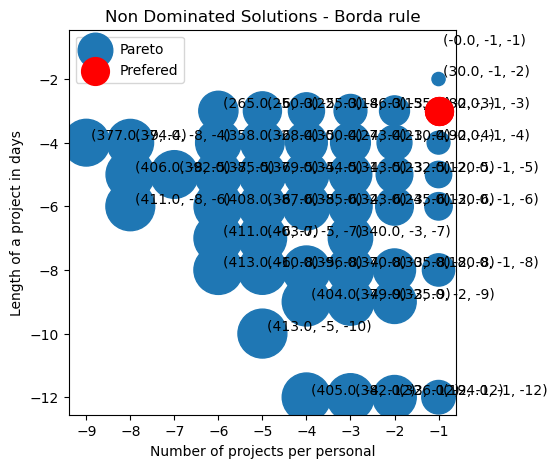

In [82]:
# Create the scatter plot
fig = plt.figure(figsize=(5,5))
plt.scatter([i[1] for i in pareto], [i[2] for i in pareto],s = [i[0]*3 for i in pareto])
# Add a title and labels for the x and y axes
for i in pareto:
    plt.text(i[1] + 0.1, i[2]+0.1,  '%s' % (str(i)), size=10, zorder=1, color='k')

# color the 3 best solutions in red according to pareto_sorted
for i in range(3):
    plt.scatter([pareto1[0][2]], [pareto1[0][3]],s = [pareto1[0][1]*5], color = 'red')

plt.title("Non Dominated Solutions - Borda rule")
plt.xlabel("Number of projects per personal")
plt.ylabel("Length of a project in days")
plt.legend(['Pareto', 'Prefered'])

# Show the plot
plt.show()

## Split the solutions to 3 groups (First Try)

In [83]:
# From the 3 objectives, we want to split the solutions into 3 groups of solutions : unacceptable, acceptable and optimal
# We set limits for each objective to split the solutions into 3 groups
# The limits are the 25th and 75th percentiles of the maximum values of each objective
# The solutions that are below the 25th percentile are unacceptable
# The solutions that are between the 25th and 75th percentiles are acceptable
# The solutions that are above the 75th percentile are optimal


unacceptable = []
acceptable = []
optimal = []

# Split the solutions using the 3 objectives together

q1_obj1 = 0.5 * sum(gj.values())
q3_obj1 = 0.75 *sum(gj.values())
q1_obj2 = -0.75 * len(J)
q3_obj2 = -0.5 * len(J)
q1_obj3 = -0.75 * len(H)
q3_obj3 = -0.5 * len(H)
print(q1_obj1, q3_obj1, q1_obj2, q3_obj2, q1_obj3, q3_obj3)

for i in pareto:
    if i[0] <= q1_obj1 or i[1] <= q1_obj2 or i[2] <= q1_obj3:
        unacceptable.append(i)
    elif i[0] >= q3_obj1 and i[1] >= q3_obj2 and i[2] >= q3_obj3:
        optimal.append(i)
    else:
        acceptable.append(i)



print("Unacceptable solutions : ", unacceptable)
print("Acceptable solutions : ", acceptable)
print("Optimal solutions : ", optimal)




255.0 382.5 -11.25 -7.5 -16.5 -11.0
Unacceptable solutions :  [(250.0, -5, -3), (225.0, -4, -3), (186.0, -3, -3), (245.0, -2, -6), (232.0, -2, -5), (210.0, -2, -4), (155.0, -2, -3), (194.0, -1, -12), (180.0, -1, -8), (130.0, -1, -6), (120.0, -1, -5), (90.0, -1, -4), (80.0, -1, -3), (30.0, -1, -2), (-0.0, -1, -1)]
Acceptable solutions :  [(377.0, -9, -4), (411.0, -8, -6), (406.0, -8, -5), (374.0, -8, -4), (358.0, -6, -4), (265.0, -6, -3), (379.0, -5, -5), (328.0, -5, -4), (405.0, -4, -12), (344.0, -4, -5), (300.0, -4, -4), (382.0, -3, -12), (379.0, -3, -9), (370.0, -3, -8), (340.0, -3, -7), (323.0, -3, -6), (313.0, -3, -5), (273.0, -3, -4), (326.0, -2, -12), (325.0, -2, -9), (305.0, -2, -8)]
Optimal solutions :  [(392.0, -7, -5), (413.0, -6, -8), (411.0, -6, -7), (408.0, -6, -6), (385.0, -6, -5), (413.0, -5, -10), (410.0, -5, -8), (403.0, -5, -7), (387.0, -5, -6), (404.0, -4, -9), (396.0, -4, -8), (385.0, -4, -6)]


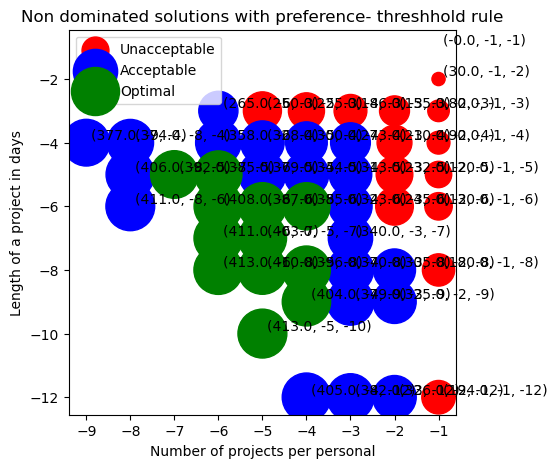

In [84]:
# Create the scatter plot
fig = plt.figure(figsize=(5,5))
plt.scatter([i[1] for i in unacceptable], [i[2] for i in unacceptable],s = [i[0]*3 for i in unacceptable],color= 'r')
plt.scatter([i[1] for i in acceptable], [i[2] for i in acceptable],s = [i[0]*3 for i in acceptable], color = 'b')
plt.scatter([i[1] for i in optimal], [i[2] for i in optimal],s = [i[0]*3 for i in optimal], color = 'g')
# Add a title and labels for the x and y axes
for i in pareto:
    plt.text(i[1] + 0.1, i[2]+0.1,  '%s' % (str(i)), size=10, zorder=1, color='k')



plt.title("Non dominated solutions with preference- threshhold rule")
plt.xlabel("Number of projects per personal")
plt.ylabel("Length of a project in days")
plt.legend(['Unacceptable', 'Acceptable','Optimal'])

# Show the plot
plt.show()

## Optimizing the weights and thresholds with Gurobi


In [85]:
non_dominated_solutions = pd.DataFrame(pareto, columns=['obj1', 'obj2', 'obj3'])
non_dominated_solutions.sort_values(by=['obj1'], ascending=False,inplace=True)
non_dominated_solutions

,obj1,obj2,obj3
5,413.0,-6,-8
11,413.0,-5,-10
1,411.0,-8,-6
6,411.0,-6,-7
12,410.0,-5,-8
7,408.0,-6,-6
2,406.0,-8,-5
18,405.0,-4,-12
19,404.0,-4,-9
13,403.0,-5,-7


In [93]:
from random import random, sample

def normalize_models(non_dominated_solutions,pareto):
    max_objVal = non_dominated_solutions["obj1"].max() # note
    max_duration = non_dominated_solutions["obj3"].max()
    max_assigned_jobs = non_dominated_solutions["obj2"].max()
    sols_normalized = []

    for sol in pareto:
        gain = sol[0] / max_objVal
        max_i =  sol[1] / max_assigned_jobs
        max_j =  sol[2] / max_duration
        sols_normalized.append((gain, max_i, max_j))

    return sols_normalized

# Générer des plannings aléatoires et les évaluer
def preference(pareto, sample_freq=None):
    inacceptable_models = []
    correct_models = []
    satisfying_models = []
    while (
        len(inacceptable_models) == 0
        or len(correct_models) == 0
        or len(satisfying_models) == 0
    ):
        w1, w2, w3, th1, th2 = get_random_weights()
        inacceptable_models = []
        correct_models = []
        satisfying_models = []

        for i in pareto:
            gain, max_i, max_j = i
            model_score = w1 * gain - w2 * max_i - w3 * max_j
            if model_score < th1:
                inacceptable_models.append((gain, max_i, max_j))
            elif model_score < th2:
                correct_models.append((gain, max_i, max_j))
            else:
                satisfying_models.append((gain, max_i, max_j))

    print('w1, w2, w3, th1, th2',w1, w2, w3, th1, th2)
    print('inacceptable_models, correct_models, satisfying_models',inacceptable_models, correct_models, satisfying_models)
    if sample_freq is None:
        sample_freq = random()

    sample_inacceptable_models = sample(
        inacceptable_models, max(1, int(sample_freq * len(inacceptable_models)))
    )
    sample_correct_models = sample(
        correct_models, max(1, int(sample_freq * len(correct_models)))
    )
    sample_satisfying_models = sample(
        satisfying_models, max(1, int(sample_freq * len(satisfying_models)))
    )

    return sample_inacceptable_models, sample_correct_models, sample_satisfying_models


def get_random_weights():
    w1 = random()
    w2 = random()
    w3 = random()
    th1 = random()
    th2 = random()
    w1, w2, w3 = normalize_weights(w1, w2, w3)
    return w1, w2, w3, min(th1, th2), max(th1, th2)


def normalize_weights(w1, w2, w3):
    sum_w = w1 + w2 + w3
    return w1 / sum_w, w2 / sum_w, w3 / sum_w


def find_pref_model(unacceptable, correct, satisfactory):
    model = grb.Model()

    # Define decision variables
    omega_1 = model.addVar(0.0, 1.0, vtype=GRB.CONTINUOUS, name="omega_1")
    omega_2 = model.addVar(0.0, 1.0, vtype=GRB.CONTINUOUS, name="omega_2")
    omega_3 = model.addVar(0.0, 1.0, vtype=GRB.CONTINUOUS, name="omega_3")
    th_1 = model.addVar(0.0, 1.0, vtype=GRB.CONTINUOUS, name="th_1")
    th_2 = model.addVar(0.0, 1.0, vtype=GRB.CONTINUOUS, name="th_2")
    eps = model.addVar(0.0, 1.0, vtype=GRB.CONTINUOUS, name="eps")

    # Add constraints
    model.addConstr(omega_1 + omega_2 + omega_3 == 1, name="normalisation")
    model.addConstr(omega_1 >= omega_2 , name="profit preferable to duration")
    model.addConstr(omega_2 >= omega_3 , name="number of projects preferable to duration")
    model.addConstrs(
        (   gain * omega_1 + max_i * omega_2 + max_j * omega_3 <= th_1 - eps
            for (gain, max_i, max_j) in unacceptable),name="unacceptable_max", )
    
    model.addConstrs(
        (   gain * omega_1 + max_i * omega_2 + max_j * omega_3 <= th_2 
            for (gain, max_i, max_j) in correct),name="correct_max",)

    model.addConstrs(
        (   gain * omega_1 + max_i * omega_2 + max_j * omega_3 >= th_1
            for (gain, max_i, max_j) in correct),name="correct_min",)
    
    model.addConstrs(
        (   gain * omega_1 + max_i * omega_2 + max_j * omega_3 >= th_2 + eps
            for (gain, max_i, max_j) in satisfactory),name="satisfactory_min",)

    # Objective
    model.setObjective(eps, GRB.MAXIMIZE)
    model.setParam("OutputFlag", 0)
    model.optimize()

    return omega_1.x, omega_2.x, omega_3.x, th_1.x, th_2.x


def order_solutions(pareto,non_dominated_solutions, params):
    w1, w2, w3 = params[:3]
    th1, th2 = params[3:]
    objVal = non_dominated_solutions['obj1'].values
    max_duration = non_dominated_solutions['obj3'].values
    max_assigned = non_dominated_solutions['obj2'].values
    normalized = normalize_models(non_dominated_solutions,pareto)
    score = [w1 * gain + w2 * max_i + w3 * max_j for (gain, max_i, max_j) in normalized]
    res = pd.DataFrame(
        {
            "objVal": objVal,
            "max_duration": max_duration,
            "max_assigned": max_assigned,
            "score": score,
        }
    )
    res = res.sort_values("score", ascending=False)
    res["status"] = res["score"].apply(
        lambda x: "unacceptable"
        if x < th1
        else ("correct" if x < th2 else "satisfactory")
    )

    return res, res[res['status'] == 'unacceptable'][['objVal', 'max_duration', 'max_assigned']].values.tolist(), res[res['status'] == 'correct'][['objVal', 'max_duration', 'max_assigned']].values.tolist(), res[res['status'] == 'satisfactory'][['objVal', 'max_duration', 'max_assigned']].values.tolist() 


normalized_surface =normalize_models(non_dominated_solutions,pareto)
unacceptable, correct, satisfactory = preference(
    normalized_surface, sample_freq=1.0
)
print("----------------------------------")
print("Unacceptable :",unacceptable, '\nCorrect :',correct, '\nSatisfactory :',satisfactory)
params = find_pref_model(unacceptable, correct, satisfactory)
#print(params)
print("----------------------------------")
print(order_solutions(pareto,non_dominated_solutions, params)[0])
unacceptable, correct, satisfactory  = order_solutions(pareto,non_dominated_solutions, params)[1:]


w1, w2, w3, th1, th2 0.9136835656030841 0.03282551153063542 0.05349092286628053 0.04981173151397489 0.13484041685675452
inacceptable_models, correct_models, satisfying_models [(0.7893462469733656, 2.0, 12.0), (0.46973365617433416, 1.0, 12.0), (0.4358353510895884, 1.0, 8.0), (0.31476997578692495, 1.0, 6.0), (0.29055690072639223, 1.0, 5.0), (0.2179176755447942, 1.0, 4.0), (0.1937046004842615, 1.0, 3.0), (0.07263922518159806, 1.0, 2.0), (-0.0, 1.0, 1.0)] [(0.9806295399515739, 4.0, 12.0), (0.9249394673123487, 3.0, 12.0), (0.37530266343825663, 2.0, 3.0)] [(0.9128329297820823, 9.0, 4.0), (0.9951573849878934, 8.0, 6.0), (0.9830508474576272, 8.0, 5.0), (0.9055690072639225, 8.0, 4.0), (0.9491525423728814, 7.0, 5.0), (1.0, 6.0, 8.0), (0.9951573849878934, 6.0, 7.0), (0.9878934624697336, 6.0, 6.0), (0.9322033898305084, 6.0, 5.0), (0.8668280871670703, 6.0, 4.0), (0.6416464891041163, 6.0, 3.0), (1.0, 5.0, 10.0), (0.9927360774818402, 5.0, 8.0), (0.9757869249394673, 5.0, 7.0), (0.937046004842615, 5.0,

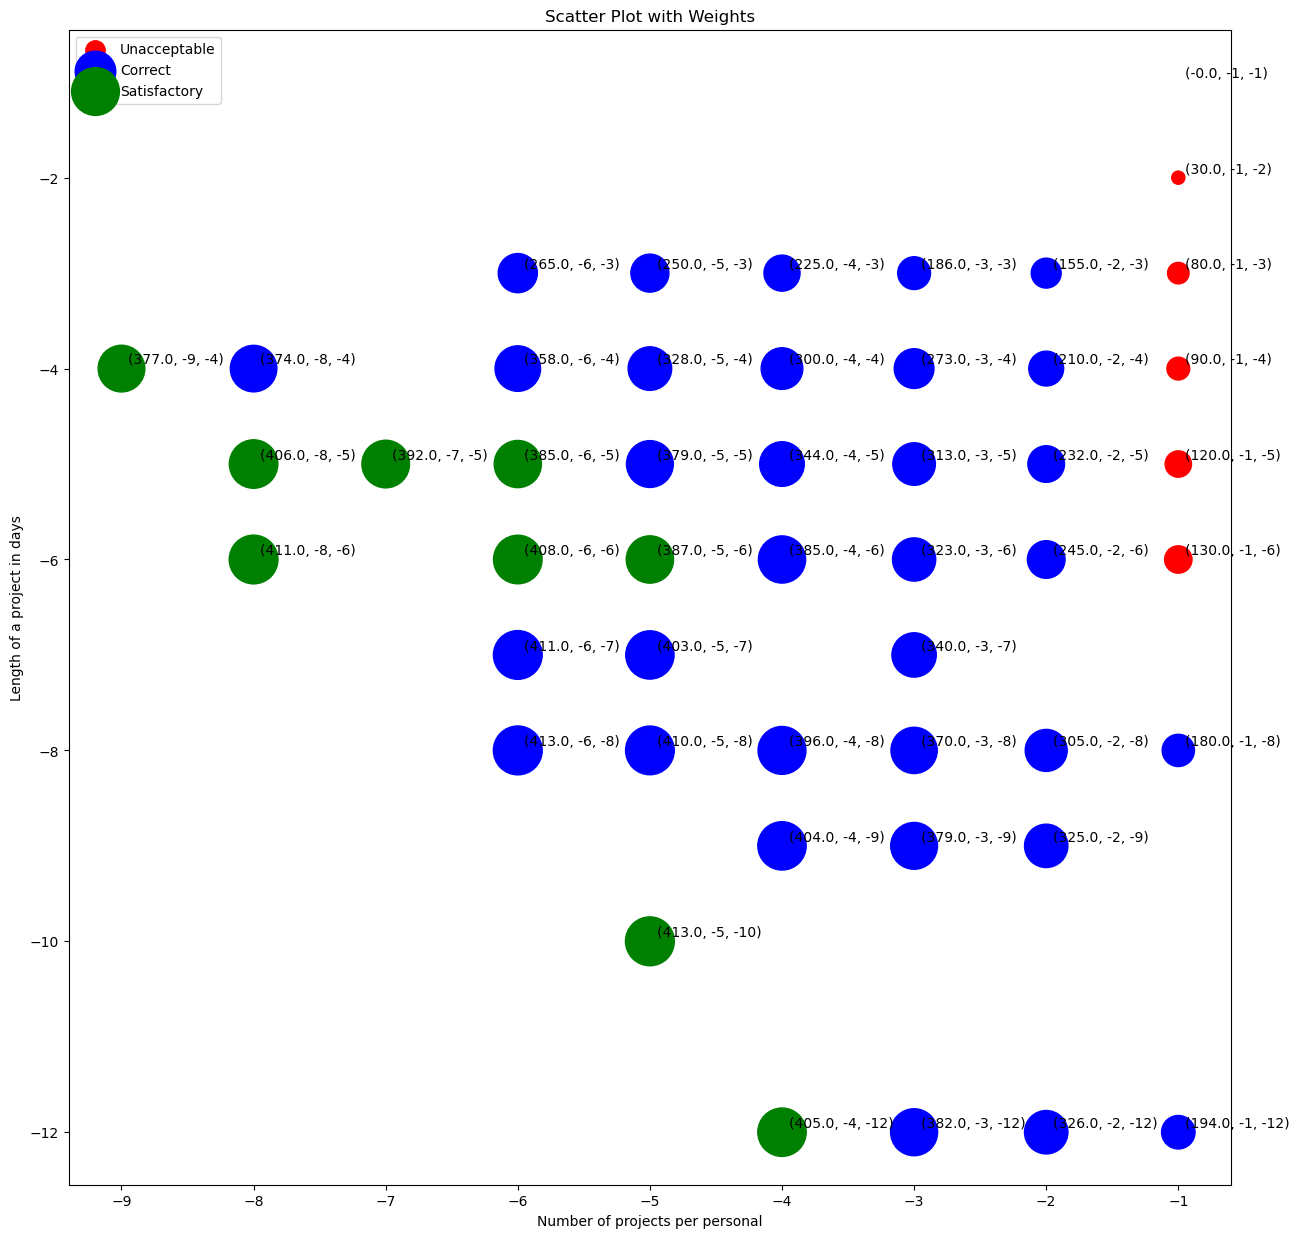

In [94]:
# Create the scatter plot
fig = plt.figure(figsize=(15,15))
plt.scatter([i[2] for i in unacceptable], [i[1] for i in unacceptable],s = [i[0]*3 for i in unacceptable],color= 'r')
plt.scatter([i[2] for i in correct], [i[1] for i in correct],s = [i[0]*3 for i in correct], color = 'b')
plt.scatter([i[2] for i in satisfactory], [i[1] for i in satisfactory],s = [i[0]*3 for i in satisfactory], color = 'g')
# Add a title and labels for the x and y axes
for i in pareto:
    plt.text(i[1] + 0.05, i[2]+0.05,  '%s' % (str(i)), size=10, zorder=1, color='k')



plt.title("Scatter Plot with Weights")
plt.xlabel("Number of projects per personal")
plt.ylabel("Length of a project in days")
plt.legend(['Unacceptable', 'Correct','Satisfactory'])

# Show the plot
plt.show()

In [88]:
# Faire des exemples de planning (inacceptables, corrects, et satisfaisants)

inacceptable = []
correct = []
satisfactory = []
for i in range(10):
    inacceptable += [generate_schedule(unacceptable)]
    correct += [generate_schedule(correct)]
    satisfactory += [generate_schedule(satisfactory)]

def generate_schedule(solutions):
    if len(solutions) == 0:
        return []
    else:
        return random.choice(solutions)




NameError: name 'generate_schedule' is not defined